# **基于MNIST数据集的嵌入式图像识别开发**
> @杨冠林

- 目标: 根据MNIST训练手写数字识别模型并部署
- 方式: 逻辑回归,Kmeans,KNN,决策树(暂不考虑)
- 数据来源: [纽约大学rowei数据库(中的mnist图片)](https://cs.nyu.edu/~roweis/data/)
- 引用: [MNIST手写数字数据库](https://blog.csdn.net/aizhao3648/article/details/101129791)
- 其他:
  1. 原始数据在`\original`文件夹下,处理后的均放置在`\post`
  2. VSCode扩展推荐:`hediet.vscode-drawio`,`mushan.vscode-paste-image`
     - `draw.io`的使用: 新建 `XXX.dio`扩展名文档,可画流程图,`E-R`图等
     - `PasteImage`的使用:

         ![](pics/2022-12-29-11-05-55.png)

         - 通过任意方式截图
         - 使用`Ctrl+Alt+V`,即可将剪贴板中的见截图保存到  `项目主文件夹/pics` 路径

----
### **检视&预处理**

选取源数据一张图片可知:

![mnist_train1.jpg](pics/2023-01-31-13-33-20.png)

- 单个手写图片为`28 × 28`,图片宽高比不一致,则实际图片数量不一致;
- 成图时有多余的块,单字分割后应根据颜色舍弃

In [1]:
from sklearn.linear_model import  LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection as sk_ms
import sklearn.metrics as sk_met
import sklearn.preprocessing as sk_pre
from imporsklearn.utils t shuffle

import torch
import torch.nn as nn
import torch.utils.data as data

from pyecharts.charts import Line,Bar,Scatter,Pie,MapGlobe
import pyecharts.options as opts
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2,pickle,netron

- 测试图片分割

In [2]:
i = cv2.imread('./original/train/mnist_train1.jpg',-1)
u,i = cv2.threshold(i,128,255,cv2.THRESH_BINARY)
i.shape

(2324, 2296)

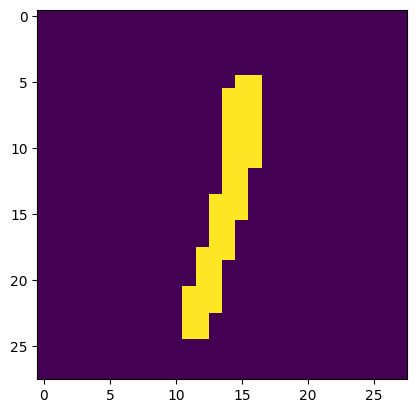

In [3]:
a = np.array([np.hsplit(line,i.shape[1]/28) for line in np.vsplit(i,i.shape[0]/28)])
plt.imshow(a[0][2])

可知,由于每个小图都是28*28,则`hsplit`针对每行,`vsplit`针对每列.
测试`a[0][2]`(即第一行第三个),发现一致,可尽数如此分割

![测试图像a](pics/2023-01-31-14-34-26.png)

分割之后,重组为`any*28*28`的数组

In [4]:
b = a.reshape((-1,28,28))
b.shape

(6806, 28, 28)

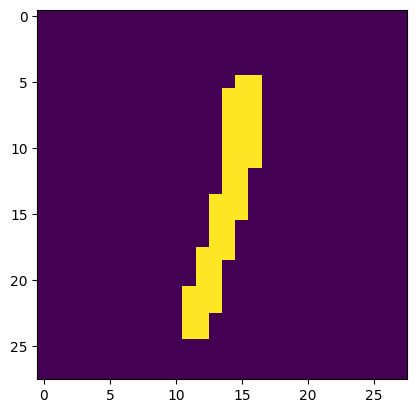

In [5]:
plt.imshow(b[2])

- 正式规整:

In [6]:
def split_cells(keyword='',num=0):
    img = cv2.imread(f'./original/{keyword}/mnist_{keyword}{str(num)}.jpg',-1)
    u,img = cv2.threshold(img,128,255,cv2.THRESH_BINARY)
    units = np.array([np.hsplit(line,img.shape[1]/28) for line in np.vsplit(img,img.shape[0]/28)])
    units = units.reshape((-1,28,28))
    resized = np.array([cv2.resize(item,(14,14)) for item in units])
    return resized

In [7]:
train_cells = [split_cells('train',i) for i in range(10)]
test_cells = [split_cells('test',i) for i in range(10)]

In [8]:
for label in range(10):
    train_cells[label] = train_cells[label].reshape((train_cells[label].shape[0],-1))
    test_cells[label] = test_cells[label].reshape((test_cells[label].shape[0],-1))

In [9]:
for label in range(10):
    train_cells[label] = np.hstack((train_cells[label],np.full((train_cells[label].shape[0],1),label)))
    test_cells[label] = np.hstack((test_cells[label],np.full((test_cells[label].shape[0],1),label)))

In [10]:
train = np.full((1,train_cells[0].shape[1]),111)
test = np.full((1,test_cells[0].shape[1]),111)
for i in range(10):
    train = np.vstack((train,train_cells[i]))
    test = np.vstack((test,test_cells[i]))

In [11]:
print(train.shape,test.shape)

(60339, 197) (10154, 197)


处理完全黑色的无用图片:

In [12]:
useless_train = [0]
useless_test = [0]
for i in range(len(train)):
    if np.mean(train[i][:-1])==0:useless_train.append(i)
for i in range(len(test)):
    if np.mean(test[i][:-1])==0:useless_test.append(i)
print(len(useless_train),len(useless_test))

339 154


归一化,存表:

In [13]:
aa = pd.DataFrame(train)
bb = pd.DataFrame(test)
aa = aa.rename(columns={196:'y'}).drop(useless_train)
bb = bb.rename(columns={196:'y'}).drop(useless_test)

In [14]:

aa.to_csv('./post/train.csv',index=False)
bb.to_csv('./post/test.csv',index=False)

----
### **训练&可视化**

- 使用`sklearn`的`逻辑回归(Logistic Regression)`处理多分类问题

> [sklearn中的logisticregression如何处理多分类？](https://zhuanlan.zhihu.com/p/78068546#:~:text=sklearn%E4%B8%AD,%E7%B1%BB%E5%88%ABa%EF%BC%8Cb%EF%BC%8Cc%E3%80%82)

In [15]:
traindata = pd.read_csv('./post/train.csv')
testdata = pd.read_csv('./post/test.csv')
traindata,testdata = shuffle(traindata),shuffle(testdata)
traindata

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,y
34673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
45294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
32106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
32647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
31393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,64,64,0,0,0,9
30903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
59902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
20640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [17]:
clf_lr = LogisticRegression()
param_lr = {
    'multi_class':['ovr', 'multinomial'],
    'solver':['lbfgs','sag'],
    'max_iter':[100,250,500]
}
gs_lr = sk_ms.GridSearchCV(clf_lr,param_lr,cv=4)

In [18]:
gs_lr.fit(traindata.iloc[:,:-1],traindata.iloc[:,-1])

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

In [20]:
clf_lr = LogisticRegression(multi_class='multinomial',max_iter=500,random_state=20)
sk_ms.cross_val_score(clf_lr,traindata.iloc[:,:-1],traindata.iloc[:,-1],cv=5).mean()


c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

0.9148666666666667

In [21]:
clf_lr.fit(traindata.iloc[:,:-1],traindata.iloc[:,-1])
pred = clf_lr.predict(testdata.iloc[:,:-1])
pred

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 6, 1, ..., 2, 6, 2], dtype=int64)

**Evaluation**
> 参考: [CSDN-机器学习模型评分总结(sklearn)](https://blog.csdn.net/wangzi11111111/article/details/88614720)

In [22]:
# 模型评估函数存于sklearn.metrics,尝试不同的评估方法
# sk_met.accuracy_score(testdata.iloc[:,-1],pred,normalize=True)
print(sk_met.classification_report(testdata.iloc[:,-1],pred))


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.89      0.90      0.90      1010
           4       0.92      0.92      0.92       982
           5       0.89      0.85      0.87       892
           6       0.94      0.95      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.86      0.88      0.87       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



- 使用`sklearn`的`K近邻算法(K Nearest Neighbors)`处理数据
> [知乎:K近邻算法介绍](https://zhuanlan.zhihu.com/p/216384870)

In [23]:
# 与kmeans一样,需要归一化
traindata_knn = (traindata.iloc[:,:-1]/255)#.to_numpy().reshape((-1,14,14))
testdata_knn = (testdata.iloc[:,:-1]/255)

In [30]:
traindata_knn.describe()

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
count,60000.0,60000.0,60000.0,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0,60000.0
mean,0.0,0.0,0.0,0.000025,0.000105,0.000280,0.000335,0.000356,0.000351,0.000159,...,0.006018,0.011290,0.013667,0.011048,0.006701,0.002868,0.000799,0.000079,0.0,0.0
std,0.0,0.0,0.0,0.002898,0.006232,0.010294,0.010638,0.010886,0.011125,0.006948,...,0.049482,0.068822,0.076551,0.070658,0.055258,0.035342,0.018268,0.005517,0.0,0.0
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
max,0.0,0.0,0.0,0.501961,0.501961,0.501961,0.749020,0.501961,0.501961,0.501961,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.501961,0.0,0.0


In [24]:
scores = []
for i in range(1,20,2):
    knc = KNeighborsClassifier(n_neighbors=i)
    knc.fit(traindata_knn,traindata.iloc[:,-1])
    scores.append([i,knc.score(testdata_knn,testdata.iloc[:,-1])])
    print(f'analysis of k == {i} completed...')
scores

analysis of k == 1 completed...
analysis of k == 3 completed...
analysis of k == 5 completed...
analysis of k == 7 completed...
analysis of k == 9 completed...
analysis of k == 11 completed...
analysis of k == 13 completed...
analysis of k == 15 completed...
analysis of k == 17 completed...
analysis of k == 19 completed...


[[1, 0.9662],
 [3, 0.968],
 [5, 0.9688],
 [7, 0.9688],
 [9, 0.9681],
 [11, 0.9657],
 [13, 0.9655],
 [15, 0.9644],
 [17, 0.9637],
 [19, 0.9625]]

In [25]:
scores = np.array(scores)
graph = (
    Line(init_opts=opts.InitOpts(width='800px',height='600px',bg_color='white'))
    .add_xaxis(scores[:,0])
    .add_yaxis('score',scores[:,1])
    .set_global_opts(
        title_opts=opts.TitleOpts('正确率-K值  折线图'),
        xaxis_opts=opts.AxisOpts(name='K'),
        yaxis_opts=opts.AxisOpts(min_=scores[:,1].min()-0.01)
    )
)
graph.render_notebook()

In [26]:
# 确定参数并评估
knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(traindata_knn,traindata.iloc[:,-1])
pred_knn = knc.predict(testdata_knn)
print(sk_met.classification_report(testdata.iloc[:,-1],pred_knn))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.96      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.98      0.94      0.96       974
           9       0.95      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



- 使用`Pytorch`的`卷积神经网络(convolutional Neural Network)`训练数据
    - 需要保持图像形状,故不做resize处理,整体流程与上皆不相同.
    - 需要借助netron可视化网络结构
> 见 [PyTorch: Training your first Convolutional Neural Network (CNN)](https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/) , [Pytorch实现卷积神经网络CNN](https://www.cnblogs.com/yangmang/p/7530748.html) 以及 [NETRON安装及使用](https://blog.csdn.net/Wenyuanbo/article/details/118736258)

In [27]:
class ConvNetwork(nn.Module):
    def __init__(self) -> None:
        super(ConvNetwork,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=1),
            # out: (14-5+2*1) / 1 + 1 = 12
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=2)
            # out: (12-2+2*2) /2 + 1 = 8
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=1),
            # out: (8-5+2*1) /1 + 1 = 6
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=1)
            # out: (6-2+2*1) /2 + 1 = 4
        )
        # self.layer3 = nn.Sequential(
        #     nn.Conv2d(in_channels=32,out_channels=64,kernel_size=4,stride=2,padding=1),
        #     # out: (8-4+2*1) /2 + 1 = 4
        #     nn.ReLU()
        # )
        self.out = nn.Sequential(
            nn.Linear(32*4*4,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        x = x.view(x.size(0), -1) # 相当于全连接层
        output = self.out(x)
        return output
    
    #实际应用中,每张图片的处理过程:
    def frame_proc(path):
        pic = cv2.imread(path,-1)
        return cv2.resize(pic,(28*28))

cnn = ConvNetwork()
print(cnn)

ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=2, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [28]:
epoch,batch,rate = 10,500,0.001
lossfunc = nn.CrossEntropyLoss()
optim = torch.optim.Adam(cnn.parameters(),lr=rate)
X_train,Y_train,X_test,Y_test = (
    traindata.iloc[:,:-1].to_numpy().reshape((-1,14,14)),
    traindata.iloc[:,-1],
    testdata.iloc[:,:-1].to_numpy().reshape((-1,14,14)),
    testdata.iloc[:,-1])

0


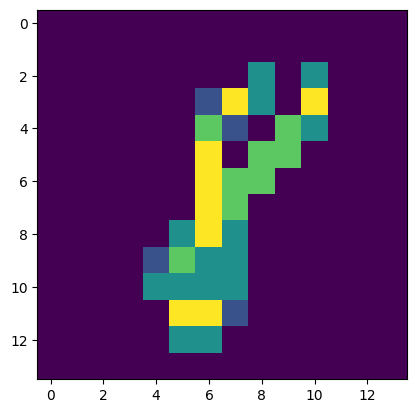

In [29]:
#验证是否转换正确
plt.imshow(X_train[0])
print(Y_train[0])

In [30]:
# 知乎拷的
class GetLoader(data.Dataset):
    def __init__(self,data_root,data_label):
        self.data = data_root
        self.label = data_label
    def __getitem__(self, index):
        d = self.data[index]
        l = self.label[index]
        return d,l
    def __len__(self):
        return len(self.data)
ddd = GetLoader(X_train,Y_train)
train_loader = data.DataLoader(ddd,batch,True,num_workers=4)

In [31]:
# 知乎拷的
for run in range(epoch):
    for step ,(b_x,b_y) in enumerate(train_loader):

        output = cnn(b_x)
        loss = lossfunc(output,b_y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if step%50 ==0:
            test_output = cnn(X_test)
            # test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == Y_test.data.numpy()).astype(int).sum()) / float(Y_test.size(0))
            print('Epoch: ', run, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

print('finish training')

: 

- **模型保存**

In [ ]:
with open('./models/clf_lr.pkl','wb')as f:pickle.dump(clf_lr,f)
with open('./models/knc.pkl','wb')as f:pickle.dump(knc,f)
# torch.save(cnn,'cnn_minist.pkl')

----
### 下位机

- [自动生成tkinter布局的网址](https://www.visualtk.com/)
- [python中tkinter窗口位置](https://zhuanlan.zhihu.com/p/339307582)

In [31]:
# 展示用,想用请执行 gui.py
import tkinter as tk
from os import system
try:
    from pickle import load
    from cv2 import imread,resize
    from PIL.ImageGrab import grab
except Exception:
    ok = system('pip install scikit-learn,torch,numpy,pandas,matplotlib,pillow,opencv-python -i https://pypi.tuna.tsinghua.edu.cn/simple')
    print('成功安装所需包...')if ok else print('未知错误...')

#事件_默认文本
def info_default(event):info['text'] = '无动作'
#事件_画图
def draw_track(event):
    l_canvas.create_oval(event.x,event.y,event.x+15,event.y+15,fill='white',outline='white',tag='track')
    info['text'] = f"坐标[{event.x},{event.y}]"
#事件_清除图像
def clear_track():l_canvas.delete('track')
#单选按钮选择事件
def selector():
    global model
    if flag.get() == 0:pass
    elif flag.get() == 1:
        with open('./models/clf_lr.pkl','rb')as f:model = load(f)
        info['text'] = 'LR模型加载完成!'
    elif flag.get() == 2:
        with open('./models/knc.pkl','rb')as f:model = load(f)
        info['text'] = 'KNN模型加载完成!'
    elif flag.get() == 3:
        with open('./models/cnn.pkl','rb')as f:model = load(f)
        info['text'] = 'CNN模型加载完成!'
#事件_执行分析
def execution():
    im=grab(bbox=(3,48,240,317))
    im.save('temp.png','PNG')
    gray = imread('./temp.png',0)
    flattened = resize(gray,(14,14)).reshape(1,-1)
    if flag.get() == 1 : info['text'] = f'LR预测: {model.predict(flattened)[0]}'
    elif flag.get() == 2 : info['text'] = f'KNN预测: {model.predict(flattened/255)[0]}'
    elif flag.get() == 3 : info['text'] = f'CNN预测: {model.predict(gray)[0]}'

model = None
selection = [
    ("LR模型",1),
    ("KNN模型",2),
    ("CNN模型",3)
]

main=tk.Tk()
main.title('MNIST手写识别')
main.geometry('480x320+0+0')
main.resizable(1,1)
flag = tk.IntVar()
#主体FRAME
frame=tk.Frame(main,width='480',height='320')
#标题label放在最上面
title_label=tk.Label(frame,width='480',height='1',text='MNIST手写识别',font=('Anrial',30),fg='yellow',bg='purple').pack(side='top')
#左边canvas画布
l_canvas=tk.Canvas(frame,width='240',height='320',bg='black',cursor='circle')
l_canvas.bind('<ButtonRelease-1>',info_default)
l_canvas.bind('<B1-Motion>',draw_track)
l_canvas.pack(side='left')
#右边FRAME
r_frame=tk.Frame(frame,width='240',height='320',bg='white')
r_frame.pack(side='right')
for t,n in selection:
    tk.Radiobutton(r_frame,width='240',height='1',text=t,value=n,variable=flag,command=selector,font=('Anrial',16,'bold'),relief='ridge',justify='left').pack(side='top')
#显示信息的messagebos
info=tk.Label(r_frame,width='240',height='6',text='无动作',font=('Anrial',16,'bold'),bg='gray',fg='red')
info.pack(side='top')
#右下层FRAME
rb_frame=tk.Frame(r_frame,width='240',height='60',bg='yellow')
#清除所画图形的按键
btn_clear=tk.Button(rb_frame,width='6',height='3',font=('Anrial',16,'bold'),fg='white',bg='yellow',text='清除',relief='ridge',command=clear_track).pack(side='left')
#执行分析的按键
btn_exec=tk.Button(rb_frame,width='6',height='3',font=('Anrial',16,'bold'),fg='white',bg='green',text='分析',relief='raised',command=execution).pack(side='left')
#退出的按键
btn_save=tk.Button(rb_frame,width='6',height='3',font=('Anrial',16,'bold'),fg='white',bg='red',text='退出',relief='solid',command=main.destroy).pack(side='left')

rb_frame.pack(side='bottom')
frame.pack()

main.overrideredirect(True)
main.mainloop()


# 转存为.py放置在RaspberryPi中

----
### 树莓派的配置

1. 硬件
   - 配置:
   > RaspberryPi 4B , 网线 × 1 , 3.5寸LCD屏 × 1 , 8g以上SD卡 × 1

2. 准备
   - 烧写:
     1. [official image RPi4](https://www.raspberrypi.com/software/operating-systems/)下载镜像
     2. 使用`win32diskimager`或者树莓派`官网的烧录软件`写入读卡器中的SD卡,点击设置按钮,`填入默认账密和wifi(非常重要)`
     
     ![imager](pics/2023-02-04-00-56-39.png)

     ![setup](pics/2023-02-04-01-36-35.png)

     3. 烧录完成后,U盘只显示`bootloader`的小部分文件,添加一个`ssh`空文件
     
     ![ssh文件](pics/2023-02-04-01-33-25.png)
     
   - 连接并上传
     1. `ssh连接`测试:
        
      ![ssh连接](pics/2023-02-04-03-46-19.png)
     
     2. 安装驱动,参考[微雪官网](https://www.waveshare.net/wiki/3.5inch_RPi_LCD_(A))
     3. 上传,调试:
      只需上传`pickle`包装好的`models\`文件夹以及GUI程序即可
     
     ![remote vscode](pics/2023-02-04-04-04-46.png)
     
     4. 设置开机自启:[树莓派开机自启自定义程序的方法](https://blog.csdn.net/qq_45615475/article/details/119295254)
   - 成果:
      
      ![](pics/2023-02-04-09-20-42.png)
      ![](pics/2023-02-04-09-23-15.png)